<a href="https://colab.research.google.com/github/keithferns98/DeepLearning/blob/main/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 95% 141M/149M [00:01<00:00, 95.9MB/s]
100% 149M/149M [00:01<00:00, 113MB/s] 


In [14]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [15]:
import tensorflow.keras
import tensorflow as tf
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *

In [20]:
train_dir='Training/'
train_paths=[]
for label in os.listdir(train_dir):
  for file in os.listdir(train_dir+label):
    train_paths.append(train_dir+label+'/'+file)
random.shuffle(train_paths)
print(train_paths[0])


Training/glioma/Tr-gl_0443.jpg


In [22]:
test_dir='Testing/'
test_paths=[]
for label in os.listdir(test_dir):
  for file in os.listdir(test_dir+label):
    test_paths.append(test_dir+label+'/'+file)
random.shuffle(test_paths)
print(test_paths[0])

Testing/glioma/Te-gl_0011.jpg


In [26]:
labels = os.listdir(train_dir)
labels

['pituitary', 'notumor', 'meningioma', 'glioma']

In [35]:
labels.index('glioma')

3

In [38]:
def open_images(paths):
  images=[]
  for path in paths:
    img=load_img(path,target_size=(128,128))
    img=np.array(img)/255.0
    images.append(img)
  return np.array(images)

In [36]:
def  get_labels(paths):
  label=[]
  for path in paths:
    path = path.split('/')[-2]
    label.append(labels.index(path))
  return label


glioma


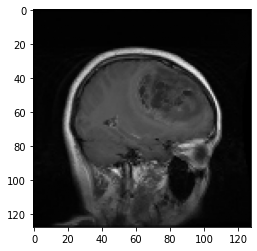

In [39]:
i=random.randint(0,len(train_paths))
label=train_paths[i].split('/')[-2]
image = open_images([train_paths[i]])
print(label)
plt.imshow(image[0])
plt.show()

In [42]:
def data_gen(data_paths,batch_size=10):
  for i in range(0,len(data_paths),batch_size):
    paths = data_paths[i:i+batch_size]
    images=open_images(paths)
    labels=labels=get_labels(paths)
    yield images,np.array(labels)

In [43]:
vgg16 = VGG16(weights='imagenet', input_shape=(128,128,3), include_top=False)
# Set all layers to non-trainable
for layer in vgg16.layers:
    layer.trainable = False
# Set the last vgg block to trainable
vgg16.layers[-2].trainable = True
vgg16.layers[-3].trainable = True
vgg16.layers[-4].trainable = True

58900480/58889256 [==============================] - 1s 0us/step


In [44]:
model = Sequential()
model.add(Input(shape=(128,128,3)))
model.add(vgg16)
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # num labels = 4

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [45]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [46]:
batch_size=20
model.fit(data_gen(train_paths), epochs=1, steps_per_epoch=int(len(train_paths)/batch_size))

285/285 [==============================] - 35s 78ms/step - loss: 0.5107 - sparse_categorical_accuracy: 0.8032


In [48]:
batch_size=20
model.evaluate(data_gen(test_paths), steps=int(len(test_paths)/batch_size))

65/65 [==============================] - 4s 61ms/step - loss: 0.3928 - sparse_categorical_accuracy: 0.8646


[0.3928295075893402, 0.8646153807640076]

Predicted: meningioma
Actual: meningioma


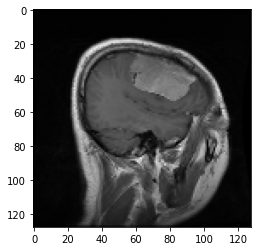

In [49]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted = model.predict(images)[0]
predicted = np.argmax(predicted)
predicted = labels[predicted]
label = test_paths[i].split('/')[-2]
plt.imshow(images[0])
print('Predicted:', predicted)
print('Actual:', label)